# Deep Neural Networks Laboration

### **Quick introduction to Jupiter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Rerunning it deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

In [18]:
# Setups
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2

### **Your task**
Your task is to make a DNN that can classify benign or malicious networks attacks using the Mirai dataset (see below). 

**You need to answer all the questions in the notebook.** Also, for all classification tasks that you will explore, you should always answer these two questions:
- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to explore and get a a hands-on experience with deep learning.

# Part 1: The Dataset #

Data used in this laboration are from the [Kitsune Network Attack Datase](https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset). We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

### **1.1 Load the data**
Complete and run the following cell to to load the the `Mirai_data.npy` and the `Mirai_labels.npy` files and remove the first 24 covariances to make the classification task harder.

In [19]:
import os
from numpy import genfromtxt # ! Not needed if you load data from numpy arrays !
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
# Load the dataset
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# Remove the first 24 covariates (columns)
X = X[:, 24:]

# Print the size of the covariates and labels
print(X.shape)
print(Y.shape)
# ============================================

(764137, 92)
(764137,)


### **1.2 Explore the data (NaNs)**
It is common to have NaNs (not a number) in the data, lets check for it.

In [20]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
#X[0,0] = np.nan
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
print(np.any(np.isnan(X)))
# Fist check for NaNs in the data and then in the labels
print(np.any(np.isnan(Y)))
# Print the number of NaNs in the covariates
np.sum(np.isnan(X))
# ============================================

False
False


0

It is also common for the data to contain outliers, so let's also check for it.

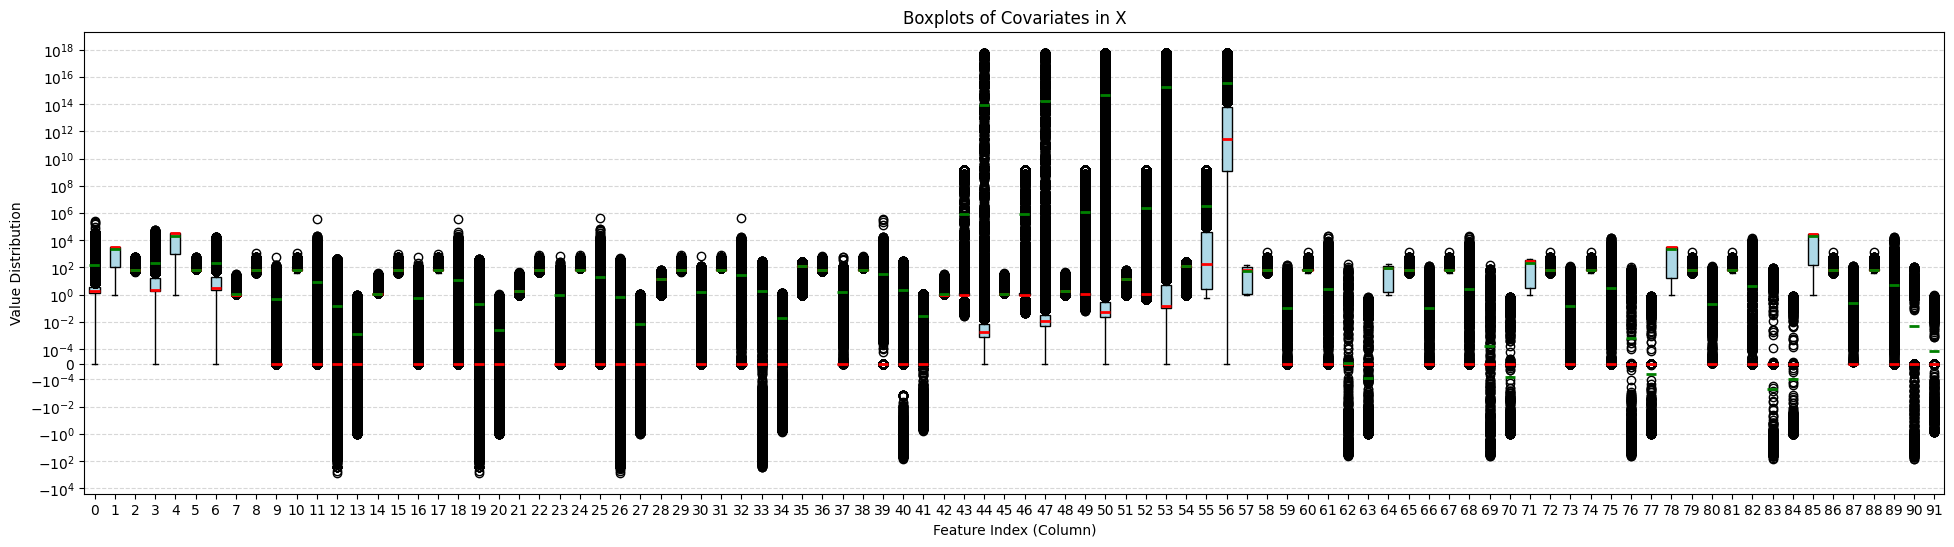

In [21]:
import matplotlib.pyplot as plt

# 1. Slice the first 10 columns (features) from your training data
# Note: If your array has fewer than 10 columns, it will just grab all of them
#first_10_cols = X_norm[:, 11:25]

# 2. Set up the figure size to give the boxes room to breathe
plt.figure(figsize=(24, 6))

# 3. Create the boxplot
# patch_artist=True allows us to fill the boxes with color
plt.boxplot(
    X, 
    patch_artist=True, 
    boxprops=dict(facecolor='lightblue', color='black'),
    medianprops=dict(color='red', linewidth=2),
    meanline= True,
    showmeans= True,
    meanprops=dict(color='green', linewidth=2, linestyle='--')
)

# 4. Format the plot for readability
plt.title('Boxplots of Covariates in X')
plt.xlabel('Feature Index (Column)')
plt.ylabel('Value Distribution')
plt.yscale('symlog', linthresh=1e-4)

# Matplotlib numbers boxes starting at 1. Let's label them 0 to 9 to match Python indices.
num_cols = X.shape[1]
plt.xticks(ticks=range(1, num_cols + 1), labels=[f'{i}' for i in range(num_cols)])

plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.show()

In [22]:
print(np.mean(X[:,44]))
print(np.median(X[:,44]))

80674155047065.3
0.0018592719804106927


We have a lot of outliers, which will impact the learning, so we will remove them first using the Interquartile method, which will remove all observations which are 1.5 IQR range above the 3rd quartile or below the 1st quartile

In [23]:
# from scipy.stats.mstats import winsorize

# X_winsorized = winsorize(X, limits=[0.05, 0.05], axis=0)

# #Check how many class 0 samples were affected
# class0_idx = np.where(Y == 0)[0]
# affected = np.any(X_winsorized[class0_idx] != X[class0_idx], axis=1)
# print(f"{affected.sum()} / {len(class0_idx)} class 0 samples were winsorized")

### **1.3 Data split**
Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables:
- `Xtrain` and `Ytrain`  (70% of the dataset)
- `Xtemp` and `Ytemp`  (30% of the dataset)

We use a function from scikit learn (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for more details)

In [24]:
from sklearn.model_selection import train_test_split

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Convert covariates to floats
X = X.astype(dtype = np.float64)

# Convert labels to integers
#Y = Y.astype(dtype = np.int64)
Y = Y.astype(dtype = np.float32)

# split the original dataset into 70% Training and 30% Temp
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.3, random_state= 3 )

# Print the number of examples of each class, for the training data and the remaining 30%
print({c : Ytrain[Ytrain== c].size for c in np.unique(Y)})
print({c : Ytemp[Ytemp == c].size for c in np.unique(Y)})


# ============================================

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

{0.0: 85229, 1.0: 449666}
{0.0: 36392, 1.0: 192850}
Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).


Now split your non-training data (`Xtemp`, `Ytemp`) into 50% validation (`Xval`, `Yval`) and 50% testing (`Xtest`, `Ytest`), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

In [25]:
from sklearn.model_selection import train_test_split

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# split the remaining 30% into 50% Validation and 50% Test
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5, random_state= 3 )

# ============================================

print(f'The validation set has size {Xval.shape[0]}')
print(f'The test set has size {Xtest.shape[0]}')

The validation set has size 114621
The test set has size 114621


#### **<span style="color:red">Questions</span>**
1. Do all variables (`Xtrain`,`Ytrain`), (`Xval`,`Yval`), (`Xtest`,`Ytest`) have the shape that you expect?
2. Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

Note, that if your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


#### **<span style="color:green">Answer</span>**
1. Yes, why wouldn't they. I just split the data and removed columns, so the shape makes sense.
2. A naive classifier, if it classified all observations as 1, would have around 84.1% accuracy in both training and test data.

### **1.4 Data preprocessing: normalization**

In [26]:
# # --------------------------------------------
# # === Your code here =========================
# # --------------------------------------------
# # Calculate normalization parameters
# mean_Xtrain = np.mean(Xtrain, axis=0)
# std_Xtrain = np.std(Xtrain, axis=0)

# # Remove mean of each covariate (column)
# Xtrain = Xtrain - mean_Xtrain
# Xtest = Xtest - mean_Xtrain
# Xval = Xval - mean_Xtrain

# # Divide each covariate (column) by its standard deviation
# Xtrain = Xtrain / std_Xtrain
# Xtest = Xtest / std_Xtrain
# Xval = Xval / std_Xtrain

# # Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
# print(np.round(np.mean(Xtrain, axis=0), 2))
# print(np.std(Xtrain, axis=0))


# ============================================


In [27]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

from sklearn.preprocessing import RobustScaler
from utilities_AB import normalize

Xtrain, Xval, Xtest = normalize(Xtrain, Xval, Xtest, method='z-score')

# ============================================


2026-02-28 18:33:28.346916: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-28 18:33:28.356147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772300008.363674  457169 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772300008.365790  457169 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-28 18:33:28.374813: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

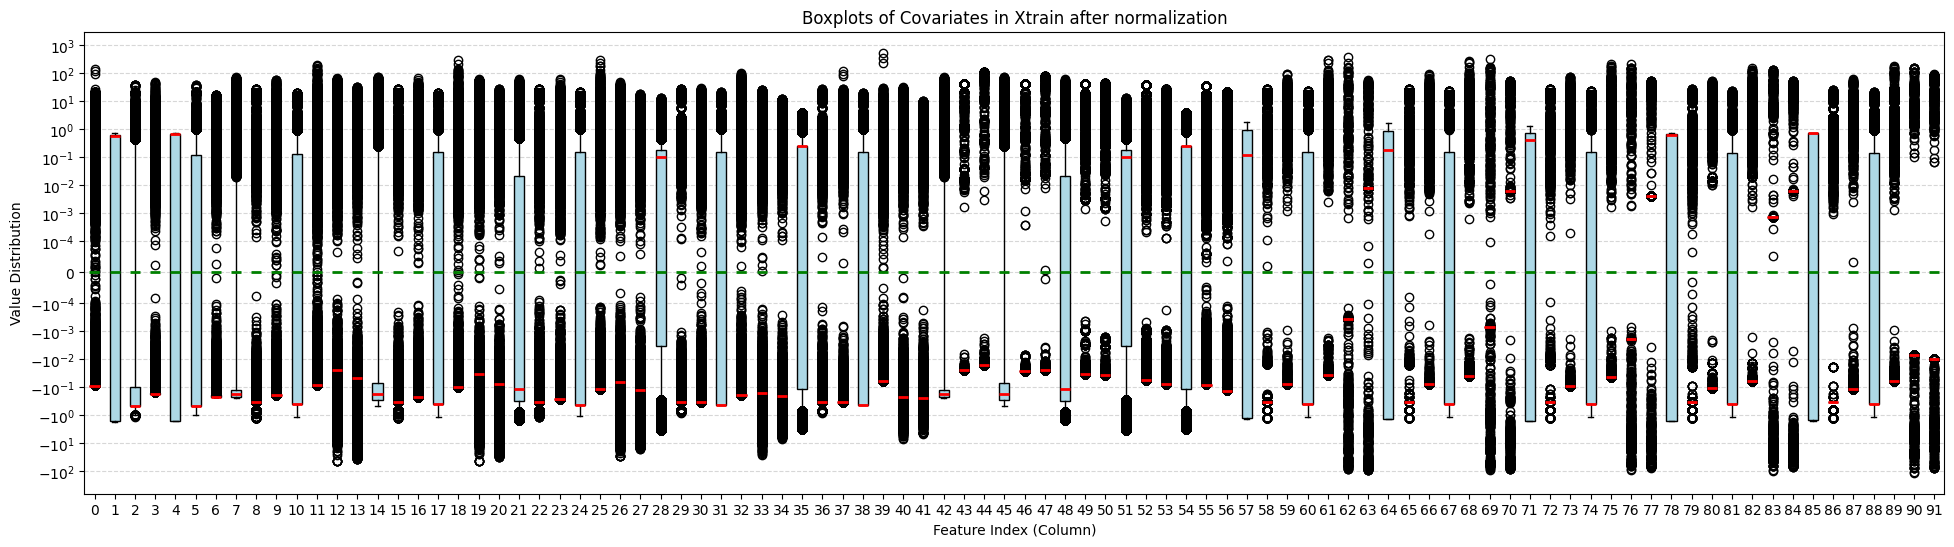

In [28]:

# 1. Slice the first 10 columns (features) from your training data
# Note: If your array has fewer than 10 columns, it will just grab all of them
#first_10_cols = X_norm[:, 11:25]

# 2. Set up the figure size to give the boxes room to breathe
plt.figure(figsize=(24, 6))

# 3. Create the boxplot
# patch_artist=True allows us to fill the boxes with color
plt.boxplot(
    Xtrain, 
    patch_artist=True, 
    boxprops=dict(facecolor='lightblue', color='black'),
    medianprops=dict(color='red', linewidth=2),
    meanline= True,
    showmeans= True,
    meanprops=dict(color='green', linewidth=2, linestyle='--')
)

# 4. Format the plot for readability
plt.title('Boxplots of Covariates in Xtrain after normalization')
plt.xlabel('Feature Index (Column)')
plt.ylabel('Value Distribution')
plt.yscale('symlog', linthresh=1e-4)

# Matplotlib numbers boxes starting at 1. Let's label them 0 to 9 to match Python indices.
num_cols = Xtrain.shape[1]
plt.xticks(ticks=range(1, num_cols + 1), labels=[f'{i}' for i in range(num_cols)])

plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.show()

In [29]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 
else:
    print('No GPU available.')

No GPU available.


2026-02-28 18:33:38.643714: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Part 2: DNN classification
In this next section you will define utilities for building the deep learning networks that will be used later and for visualizing the model training. You will also train several model experimenting with different model architecture configurations and methods for model regularization.

### **2.1 Build DNN model**
Implement the `build_DNN` and `plot_results` functions in the `utilities.py` file. Note that for the changes in the `utilities.py` definitions to be visible by the notebook, you need to save the file. 

Here are some relevant functions that you should use in `build_DNN`. For a complete list of functions and their definitions see the [keras documentation](https://keras.io/api/):

- `model.add()`, adds a layer to the network;
- `Dense()`, a dense network layer. See the [documentation](https://keras.io/api/layers/core_layers/dense/) what are the input options and outputs of the `Dense()` function. 
- `model.compile()`, compiles the model. You can set the input metrics=['accuracy'] to print the classification accuracy during the training.
- cost and loss functions: check the [documentation](https://keras.io/losses/) and chose a loss function for binary classification.

To get more information in model [compile](https://keras.io/api/models/model_training_apis/#compile-method), [training](https://keras.io/api/models/model_training_apis/#fit-method) and [evaluation](https://keras.io/api/models/model_training_apis/#evaluate-method) see the relevant documentation.

After defining the`build_DNN` function use it to create the your first DNN classifier. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

Make sure that the last layer always has a sigmoid activation function (why?).

#### **<span style="color:green">Answer</span>**
We are doing a classification, so the last layer should use the sigmoid function to output values between 0 and 1.

In [30]:
from utilities_AB import build_DNN, plot_results, MacroF1Callback
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# import a suitable loss function from keras.losses and use as input to the build_DNN function.
from tf_keras.losses import BinaryFocalCrossentropy, BinaryCrossentropy

# Build a DNN model following the specifications above
model = build_DNN(Xtrain.shape[1], n_hidden_layers= 2, n_hidden_units= 20, act_fun= 'sigmoid', loss = BinaryFocalCrossentropy(), print_summary=True)

# ============================================

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1860      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2301 (8.99 KB)
Trainable params: 2301 (8.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **2.2 Train DNN model**

Time to train the DNN!
Start simple with 2 hidden layers with 20 nodes each.

Build set the different hyper-parameters, build the model and run the training. Use the following training and hyper-parameters:
- `batch_size=20`
- `epochs=20`
- `learning_rate=0.1`

Make sure that you are using learning rate 0.1 !

### 2 hidden layers with 20 nodes each

In [31]:
# Setup some training and hyper-parameters
batch_size = 100
epochs = 40

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# Specify the learning rate, the input shape and the loss function
learning_rate = 0.1
input_shape = Xtrain.shape[1]
loss = BinaryFocalCrossentropy(gamma = 2)
#callback = MacroF1Callback(val_data=(Xval, Yval), test_data=(Xtest, Ytest))

# Build the model
model1 = build_DNN(input_shape=input_shape, n_hidden_layers= 2, n_hidden_units= 20, act_fun= 'sigmoid', loss = loss, learning_rate=learning_rate)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain, batch_size, epochs, validation_data=(Xval, Yval))
# ============================================

Epoch 1/40
5349/5349 [==============================] - 4s 636us/step - loss: 0.0462 - accuracy: 0.9032 - f1_score: 0.9411 - val_loss: 0.0404 - val_accuracy: 0.9117 - val_f1_score: 0.9457
Epoch 2/40
5349/5349 [==============================] - 3s 609us/step - loss: 0.0396 - accuracy: 0.9162 - f1_score: 0.9480 - val_loss: 0.0391 - val_accuracy: 0.9170 - val_f1_score: 0.9484
Epoch 3/40
5349/5349 [==============================] - 3s 605us/step - loss: 0.0387 - accuracy: 0.9177 - f1_score: 0.9489 - val_loss: 0.0384 - val_accuracy: 0.9169 - val_f1_score: 0.9484
Epoch 4/40
5349/5349 [==============================] - 3s 607us/step - loss: 0.0381 - accuracy: 0.9185 - f1_score: 0.9494 - val_loss: 0.0379 - val_accuracy: 0.9180 - val_f1_score: 0.9490
Epoch 5/40
5349/5349 [==============================] - 3s 627us/step - loss: 0.0376 - accuracy: 0.9193 - f1_score: 0.9499 - val_loss: 0.0375 - val_accuracy: 0.9182 - val_f1_score: 0.9492
Epoch 6/40
5349/5349 [==============================] - 3s 6

In [32]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest)

# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])
print('Test f1: %.4f' % score[2])

3582/3582 [==============================] - 1s 384us/step - loss: 0.0296 - accuracy: 0.9372 - f1_score: 0.9616
Test loss: 0.0296
Test accuracy: 0.9372
Test f1: 0.9616


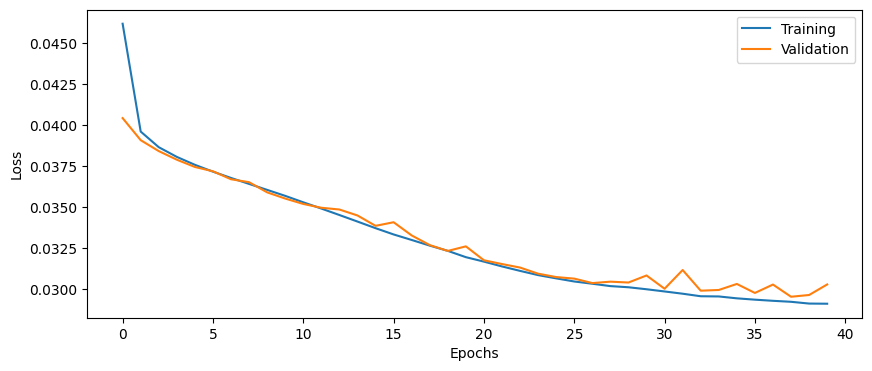

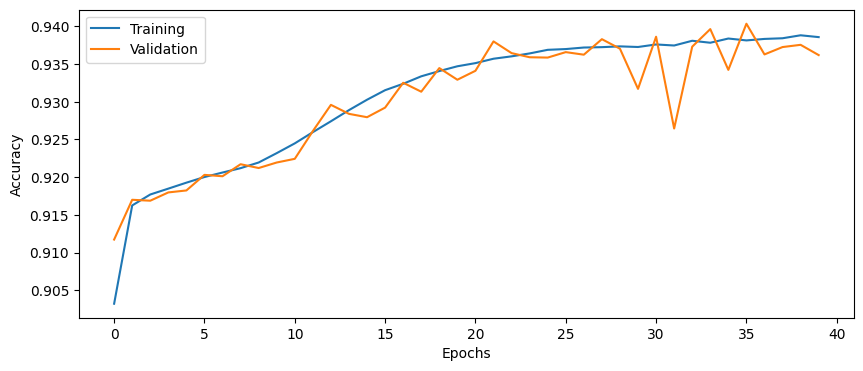

In [33]:
from utilities_AB import plot_results

# Plot the history from the training run
plot_results(history1)

#### **<span style="color:red">Questions</span>**

3. What happens if you add several Dense layers without specifying the activation function?

4. How are the weights in each dense layer initialized as default? How are the bias weights initialized?

#### **<span style="color:green">Answers</span>**
3. If I don't specify an activation function, there is no default, and then model will be akin to a logistic regression, no matter the number of layers or nodes I specify.

4. By default, the weights in each dense layer are initialized using Glorot Uniform initializer, also known as the Xavier uniform initializer, while the biases are set to zero at the start.


### **2.2 Adressing class imbalance**

This dataset is rather unbalanced with the majority of the samples belonging to class=1. We need to define class weights so that the training pays more attention to the class with fewer samples. We use the [`compute_class_weight`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) function from `scikit-learn`.

You need to call the function something like this
```python
class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )
```

otherwise it will through an error.

In [34]:
from sklearn.utils import class_weight

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# Calculate class weights
value1, value2 = class_weight.compute_class_weight(class_weight = 'balanced' , classes = np.array([0,1]), y = Ytrain)


# Print the class weights
print(value1)
print(value2)

# ============================================

# Convert class weights into a dictionary that can be used as input to the model.fit() function

class_weights = {0: value1,
                1: value2}


3.137987070128712
0.5947692287164251


### Train a model using class weights. 2 hidden layers with 20 nodes each


In [35]:
# Setup some training and hyper-parameters
batch_size = 100
epochs = 20

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# Specify the learning rate, the input shape and the loss function
learning_rate = 0.1
input_shape = Xtrain.shape[1]
loss = BinaryCrossentropy()

# Build the model
model3 = build_DNN(input_shape=input_shape, n_hidden_layers= 2, n_hidden_units= 20, act_fun= 'sigmoid', print_summary= True, loss = loss, learning_rate=learning_rate)


# Train the model, provide training data and validation data
history3 = model3.fit(Xtrain, Ytrain, batch_size, epochs, validation_data=(Xval, Yval), class_weight=class_weights)
# ============================================

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                1860      
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2301 (8.99 KB)
Trainable params: 2301 (8.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
5349/5349 [==============================] - 4s 710us/step - loss: 0.1903 - accuracy: 0.9040 - f1_score: 0.9395 - val_loss: 0.2081 - val_accuracy: 0.9153 - val_f1_score: 0.9470
Epoch 2/20
5349/5349 [==============================] - 4s 684us/step - loss: 0.1639 - accuracy: 0

In [36]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest)

# ============================================
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])
print('Test f1: %.4f' % score[2])

3582/3582 [==============================] - 1s 359us/step - loss: 0.1563 - accuracy: 0.9338 - f1_score: 0.9591
Test loss: 0.1563
Test accuracy: 0.9338
Test f1: 0.9591


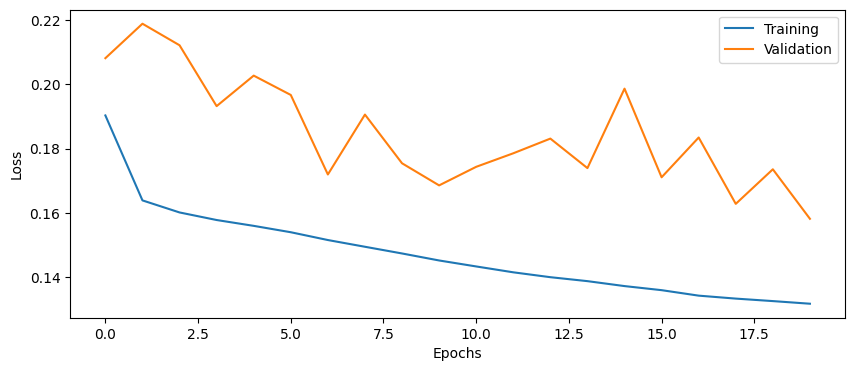

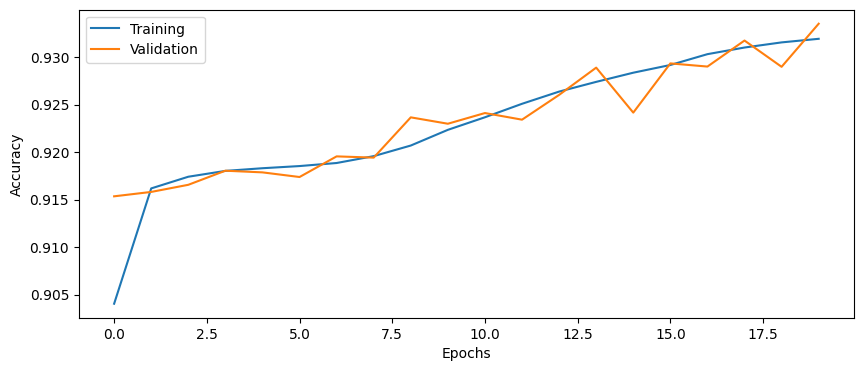

In [37]:
plot_results(history3)

### **Additional questions**
#### **<span style="color:red">Questions</span>**

5. Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

6. What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

7. How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

8. What limits how large the batch size can be?

9.  Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?
10. How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()
   
#### **<span style="color:green">Answers</span>**
5. We need to use batch size because calculating a gradient descent for large datasets would be very expensive computationally and would not fit in the RAM. So instead, one uses a stochastic gradient descent that computes the gradient for a smaller batch. Assuming the batches are independently sampled, one would have a good approximation of the distribution landscape and, thus, be able to get closer to the optimum at each batch iteration. It's also good that the gradient is a bit noisy so that we can explore instead of getting stuck at a peak.

6. When the batch size is 100, the processing time is 18 seconds. For 1000 it is 3 second; for 10 000 is also 2 second. This is because, as the batch size decreases, each step is faster but a larger number of steps are needed. When we increase the batch size, it time per batch increases but less steps are needed. Since it is faster to do matrix calculation or parallalize the operations than it is to iterate, there is a gain in speed. 

7. The weights are updated 5349, 535 and 54 times in an epoch, respectively for batch size 100, 1000 and 10000.

8. The RAM in the CPU and in the GPU to store the batch dataset, the weights and the gradients calculations and the values for the neuron.

9. If the batch size is decreased, the learning rate should be reduced. Not only there are more steps, so each step should be smaller, the batch is not as representative of the distribution so the algorithm could be taking a very confident step towards a wrong solution. 

10. With 4 dense layers and 50 nodes each, there are 12 351 trainable parameters in the network, versus 2 301 parameters with 2 dense layers and 20 nodes each.

### **2.3 Model regularization**

In the following sections you will explore methods for model normalization, namely `BatchNormalization` and `Dropout`, and also look at the impact of ofter activation functions and optimization algorithms.
#### **2.3.1 Batch normalization**

Now add batch normalization after each hidden dense layer in `build_DNN`.

See the [documentation](https://keras.io/layers/normalization/) for information about how to call the function.

#### **<span style="color:red">Questions</span>**
11. Why is batch normalization important when training deep networks?

#### **<span style="color:green">Answers</span>**
[Your answers here]

### 2 hidden layers, 20 nodes each, class weights and batch normalization

In [38]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Build and train model

# Setup some training and hyper-parameters
batch_size = 100
epochs = 20

# Specify the learning rate, the input shape and the loss function
learning_rate = 0.1
input_shape = Xtrain.shape[1]
loss = BinaryCrossentropy()

model6 = build_DNN(input_shape=input_shape, n_hidden_layers= 2, n_hidden_units= 20, act_fun= 'sigmoid', loss = loss, print_summary=False, learning_rate=learning_rate, use_bn=True)


history6 = model6.fit(Xtrain, Ytrain, batch_size, epochs, validation_data=(Xval, Yval), class_weight=class_weights)

# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest)


Epoch 1/20
5349/5349 [==============================] - 5s 904us/step - loss: 0.1746 - accuracy: 0.9143 - f1_score: 0.9463 - val_loss: 0.1906 - val_accuracy: 0.9178 - val_f1_score: 0.9486
Epoch 2/20
5349/5349 [==============================] - 5s 898us/step - loss: 0.1616 - accuracy: 0.9177 - f1_score: 0.9486 - val_loss: 0.1935 - val_accuracy: 0.9178 - val_f1_score: 0.9486
Epoch 3/20
5349/5349 [==============================] - 5s 870us/step - loss: 0.1555 - accuracy: 0.9193 - f1_score: 0.9496 - val_loss: 0.1992 - val_accuracy: 0.9190 - val_f1_score: 0.9494
Epoch 4/20
5349/5349 [==============================] - 5s 885us/step - loss: 0.1499 - accuracy: 0.9225 - f1_score: 0.9517 - val_loss: 0.1683 - val_accuracy: 0.9270 - val_f1_score: 0.9546
Epoch 5/20
5349/5349 [==============================] - 5s 864us/step - loss: 0.1443 - accuracy: 0.9260 - f1_score: 0.9540 - val_loss: 0.1643 - val_accuracy: 0.9309 - val_f1_score: 0.9571
Epoch 6/20
5349/5349 [==============================] - 5s 8

Test loss: 0.1425
Test accuracy: 0.9354
Test f1: 0.9607


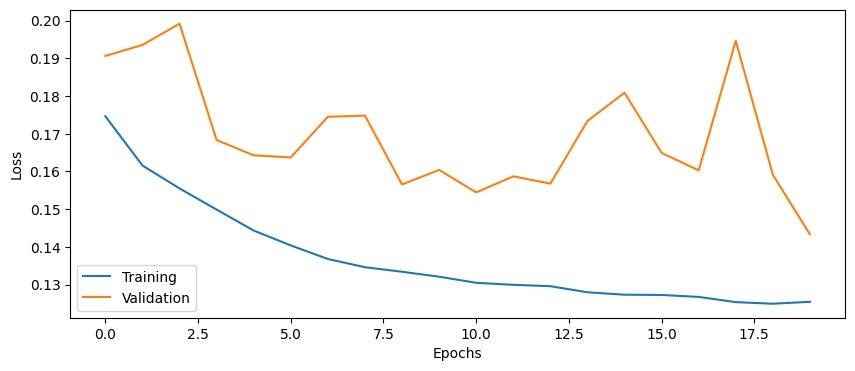

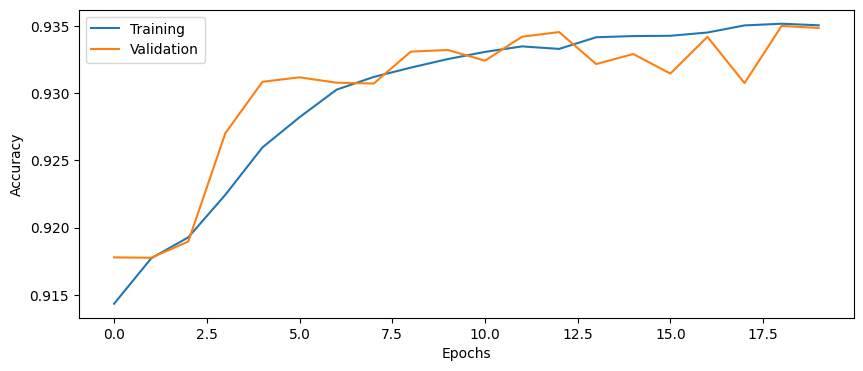

In [39]:

# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])
print('Test f1: %.4f' % score[2])

# Plot the history from the training run
plot_results(history6)

#### **2.3.2 Activation function**

Try changing the activation function in each layer from sigmoid to [ReLU](https://keras.io/api/layers/activations/).

**Note**: the last layer should still have a sigmoid activation function.

### 2 hidden layers, 20 nodes each, class weights, ReLU and no batch normalization

In [40]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Setup some training and hyper-parameters
batch_size = 100
epochs = 20

# Specify the learning rate, the input shape and the loss function
learning_rate = 0.1
input_shape = Xtrain.shape[1]
loss = BinaryCrossentropy()


# Build and train model
model7 = build_DNN(input_shape=input_shape, n_hidden_layers= 2, n_hidden_units= 20, act_fun= 'relu', loss = loss, print_summary=True, learning_rate=learning_rate)

history7 = model7.fit(Xtrain, Ytrain, batch_size, epochs, validation_data=(Xval, Yval), class_weight=class_weights)

# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                1860      
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2301 (8.99 KB)
Trainable params: 2301 (8.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
5349/5349 [==============================] - 4s 688us/step - loss: 0.1771 - accuracy: 0.9118 - f1_score: 0.9447 - val_loss: 0.2172 - val_accuracy: 0.9163 - val_f1_score: 0.9476
Epoch 2/20
5349/5349 [==============================] - 3s 646us/step - loss: 0.1604 - accuracy: 0

Test loss: 0.1560
Test accuracy: 0.9348
Test f1: 0.9597


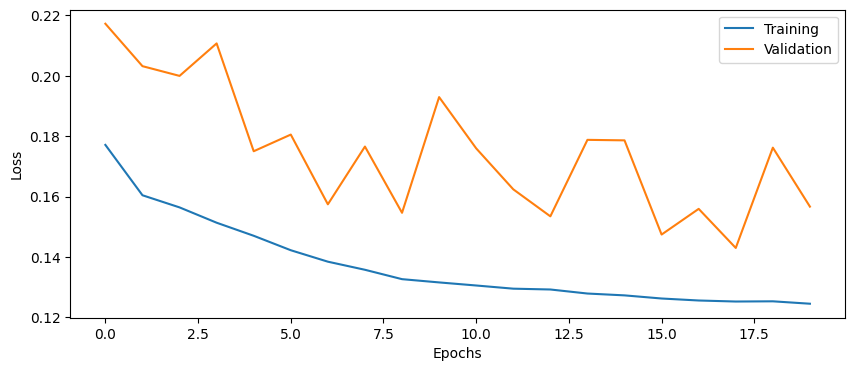

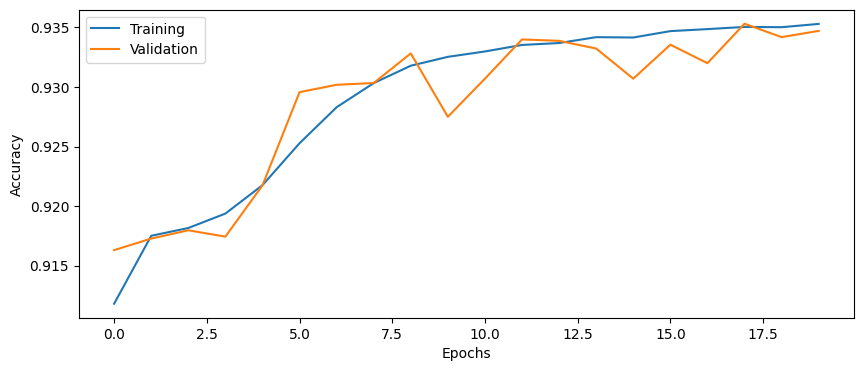

In [41]:
# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])
print('Test f1: %.4f' % score[2])

# Plot the history from the training run
plot_results(history7)

#### **2.3.3 Optimizer**

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from [keras.optimizers](https://keras.io/optimizers/). 

### 2 hidden layers, 20 nodes each, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [42]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Setup some training and hyper-parameters
batch_size = 100
epochs = 20

# Specify the learning rate, the input shape and the loss function
learning_rate = 0.1
input_shape = Xtrain.shape[1]
loss = BinaryCrossentropy()

# Build and train model
model8 = build_DNN(input_shape=input_shape, n_hidden_layers= 2, n_hidden_units= 20, act_fun= 'sigmoid', loss = loss, optimizer='adam', learning_rate=learning_rate)

history8 = model8.fit(Xtrain, Ytrain, batch_size, epochs, validation_data=(Xval, Yval), class_weight=class_weights)

# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest)


Epoch 1/20
5349/5349 [==============================] - 4s 725us/step - loss: 0.1749 - accuracy: 0.9121 - f1_score: 0.9449 - val_loss: 0.1991 - val_accuracy: 0.9152 - val_f1_score: 0.9469
Epoch 2/20
5349/5349 [==============================] - 4s 705us/step - loss: 0.1713 - accuracy: 0.9137 - f1_score: 0.9459 - val_loss: 0.2214 - val_accuracy: 0.9093 - val_f1_score: 0.9430
Epoch 3/20
5349/5349 [==============================] - 4s 671us/step - loss: 0.1713 - accuracy: 0.9138 - f1_score: 0.9460 - val_loss: 0.2253 - val_accuracy: 0.9139 - val_f1_score: 0.9460
Epoch 4/20
5349/5349 [==============================] - 4s 724us/step - loss: 0.1702 - accuracy: 0.9149 - f1_score: 0.9467 - val_loss: 0.2032 - val_accuracy: 0.9154 - val_f1_score: 0.9470
Epoch 5/20
5349/5349 [==============================] - 4s 691us/step - loss: 0.1728 - accuracy: 0.9139 - f1_score: 0.9461 - val_loss: 0.2134 - val_accuracy: 0.9150 - val_f1_score: 0.9467
Epoch 6/20
5349/5349 [==============================] - 4s 6

Test loss: 0.2197
Test accuracy: 0.9139
Test f1: 0.9461


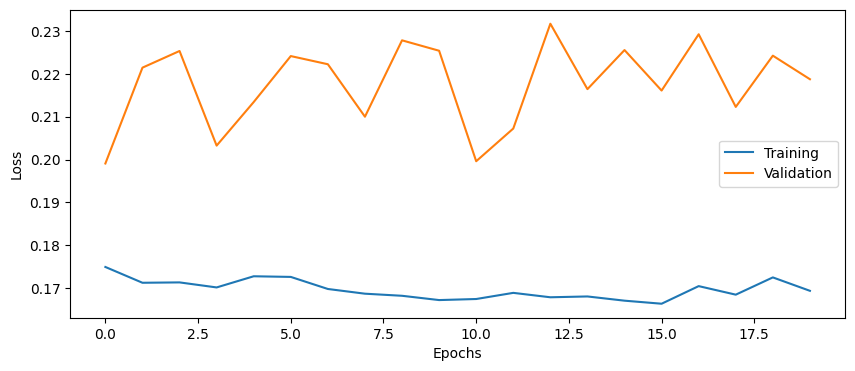

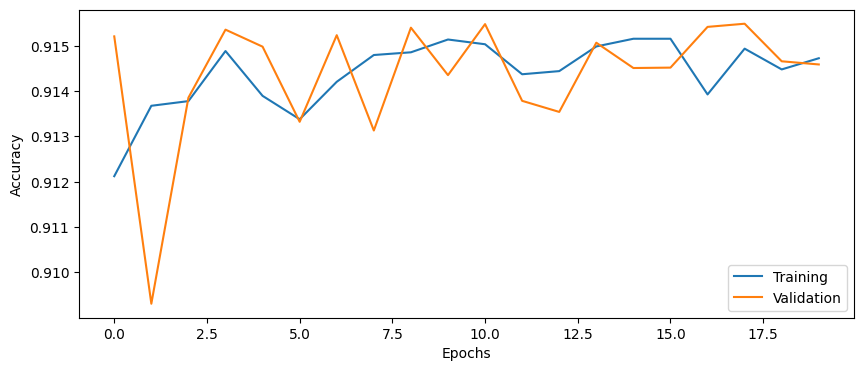

In [43]:
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])
print('Test f1: %.4f' % score[2])

# Plot the history from the training run
plot_results(history8)

#### 2.3.4 **Dropout regularization**

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Look at the [documentation](https://keras.io/api/layers/regularization_layers/dropout/) for more information on how to call set this layer.

#### **<span style="color:red">Questions</span>**
12. How does the validation accuracy change when adding dropout?
13. How does the test accuracy change when adding dropout?

#### **<span style="color:green">Answers</span>**
12. The validations accuracy starts very high and remains quite constant over the training, even though the training accuracy is growing.
13. The test accuracy decreases very slightly.

### 2 hidden layers with 20 nodes each, class weights, dropout, SGD optimizer, no batch normalization and sigmoid activations

In [44]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Setup some training and hyper-parameters
batch_size = 100
epochs = 20

# Specify the learning rate, the input shape and the loss function
learning_rate = 0.1
input_shape = Xtrain.shape[1]
loss = BinaryCrossentropy()

# Build and train model
model9 = build_DNN(input_shape=input_shape, n_hidden_layers= 2, n_hidden_units= 20, act_fun= 'sigmoid', use_dropout=True, loss = loss, optimizer='sgd', learning_rate=learning_rate)

history9 = model9.fit(Xtrain, Ytrain, batch_size, epochs, validation_data=(Xval, Yval), class_weight=class_weights)

# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest)


Epoch 1/20
5349/5349 [==============================] - 5s 786us/step - loss: 0.2506 - accuracy: 0.8758 - f1_score: 0.9208 - val_loss: 0.2350 - val_accuracy: 0.9029 - val_f1_score: 0.9387
Epoch 2/20
5349/5349 [==============================] - 4s 732us/step - loss: 0.1962 - accuracy: 0.9009 - f1_score: 0.9374 - val_loss: 0.2214 - val_accuracy: 0.9103 - val_f1_score: 0.9436
Epoch 3/20
5349/5349 [==============================] - 4s 767us/step - loss: 0.1876 - accuracy: 0.9056 - f1_score: 0.9405 - val_loss: 0.2185 - val_accuracy: 0.9148 - val_f1_score: 0.9466
Epoch 4/20
5349/5349 [==============================] - 4s 748us/step - loss: 0.1846 - accuracy: 0.9072 - f1_score: 0.9416 - val_loss: 0.2139 - val_accuracy: 0.9149 - val_f1_score: 0.9467
Epoch 5/20
5349/5349 [==============================] - 4s 766us/step - loss: 0.1819 - accuracy: 0.9085 - f1_score: 0.9425 - val_loss: 0.2170 - val_accuracy: 0.9151 - val_f1_score: 0.9468
Epoch 6/20
5349/5349 [==============================] - 4s 7

Test loss: 0.2151
Test accuracy: 0.9152
Test f1: 0.9470


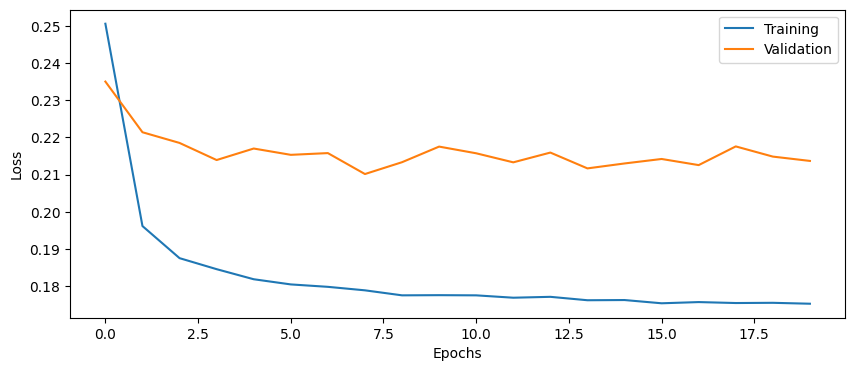

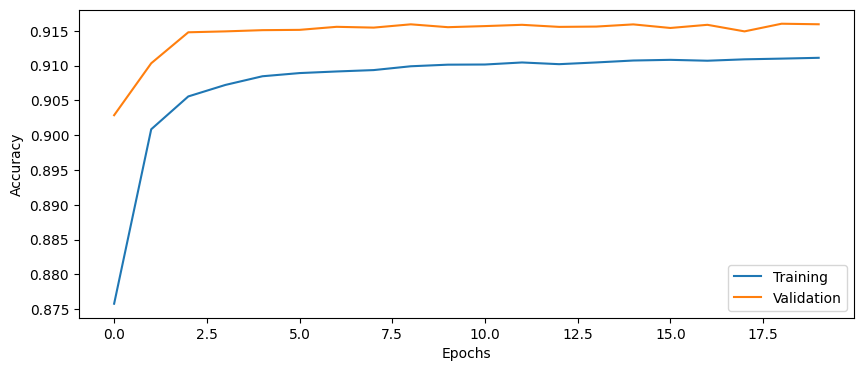

In [45]:

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])
print('Test f1: %.4f' % score[2])


# Plot the history from the training run
plot_results(history9)

# Part 3:  Hyper parameter tuning

### **3.1 Manual hyper parameter tuning**
Spend some time (20 to 30 minutes) tuning the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

#### **<span style="color:red">Question</span>**
14. How high classification accuracy can you achieve for the test data? What is your best configuration?
   
#### **<span style="color:green">Answers</span>**
[Your answers here]

In [46]:
# Setup some training and hyper-parameters
batch_size = 1000
epochs = 50

# Specify the learning rate, the input shape and the loss function
learning_rate = 0.03
input_shape = Xtrain.shape[1]
loss = BinaryFocalCrossentropy(label_smoothing=0.01)

# Build and train model
model10 = build_DNN(input_shape=input_shape, n_hidden_layers= 5, n_hidden_units= 50, act_fun= 'relu', use_bn= True, loss = loss, optimizer='adam', learning_rate=learning_rate)

history10 = model10.fit(Xtrain, Ytrain, batch_size, epochs, validation_data=(Xval, Yval))

# Evaluate model on test data
score = model10.evaluate(Xtest, Ytest)

Epoch 1/50
535/535 [==============================] - 4s 5ms/step - loss: 0.0429 - accuracy: 0.9107 - f1_score: 0.9449 - val_loss: 0.0370 - val_accuracy: 0.9184 - val_f1_score: 0.9496
Epoch 2/50
535/535 [==============================] - 2s 5ms/step - loss: 0.0361 - accuracy: 0.9213 - f1_score: 0.9517 - val_loss: 0.0610 - val_accuracy: 0.9172 - val_f1_score: 0.9483
Epoch 3/50
535/535 [==============================] - 2s 4ms/step - loss: 0.0335 - accuracy: 0.9283 - f1_score: 0.9561 - val_loss: 0.0534 - val_accuracy: 0.8996 - val_f1_score: 0.9409
Epoch 4/50
535/535 [==============================] - 2s 4ms/step - loss: 0.0318 - accuracy: 0.9318 - f1_score: 0.9583 - val_loss: 0.0330 - val_accuracy: 0.9297 - val_f1_score: 0.9568
Epoch 5/50
535/535 [==============================] - 2s 4ms/step - loss: 0.0308 - accuracy: 0.9339 - f1_score: 0.9596 - val_loss: 0.0392 - val_accuracy: 0.9238 - val_f1_score: 0.9529
Epoch 6/50
535/535 [==============================] - 2s 4ms/step - loss: 0.0306

Test loss: 0.1724
Test accuracy: 0.9304
Test f1: 0.9585


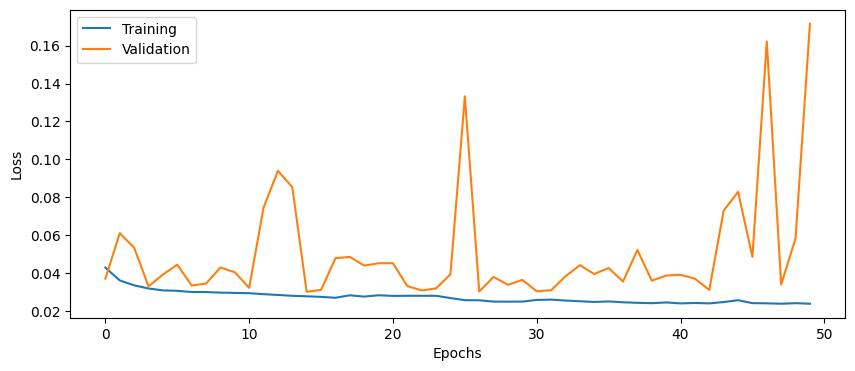

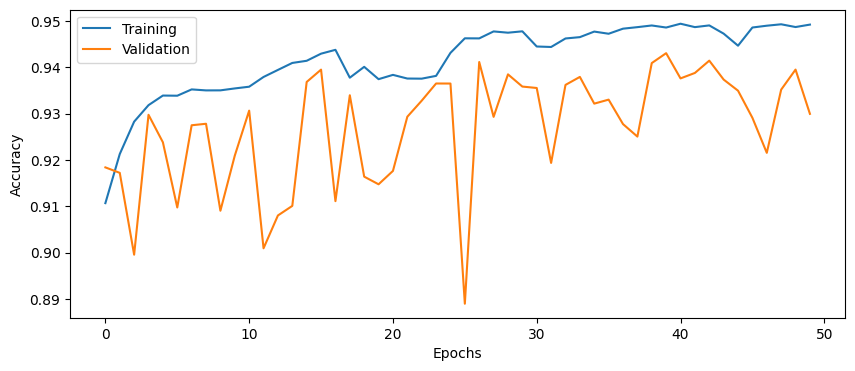

In [47]:
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])
print('Test f1: %.4f' % score[2])


# Plot the history from the training run
plot_results(history10)

Epoch 1/50
54/54 [==============================] - 3s 28ms/step - loss: 0.0852 - accuracy: 0.8740 - f1_score: 0.9195 - val_loss: 1.1343 - val_accuracy: 0.8775 - val_f1_score: 0.9214
Epoch 2/50
54/54 [==============================] - 1s 21ms/step - loss: 0.0463 - accuracy: 0.9139 - f1_score: 0.9461 - val_loss: 0.3074 - val_accuracy: 0.8938 - val_f1_score: 0.9326
Epoch 3/50
54/54 [==============================] - 1s 18ms/step - loss: 0.0453 - accuracy: 0.9156 - f1_score: 0.9472 - val_loss: 0.1249 - val_accuracy: 0.9020 - val_f1_score: 0.9381
Epoch 4/50
54/54 [==============================] - 1s 18ms/step - loss: 0.0450 - accuracy: 0.9161 - f1_score: 0.9475 - val_loss: 0.0829 - val_accuracy: 0.9123 - val_f1_score: 0.9450
Epoch 5/50
54/54 [==============================] - 1s 17ms/step - loss: 0.0439 - accuracy: 0.9171 - f1_score: 0.9482 - val_loss: 0.0646 - val_accuracy: 0.9164 - val_f1_score: 0.9476
Epoch 6/50
54/54 [==============================] - 1s 17ms/step - loss: 0.0440 - acc

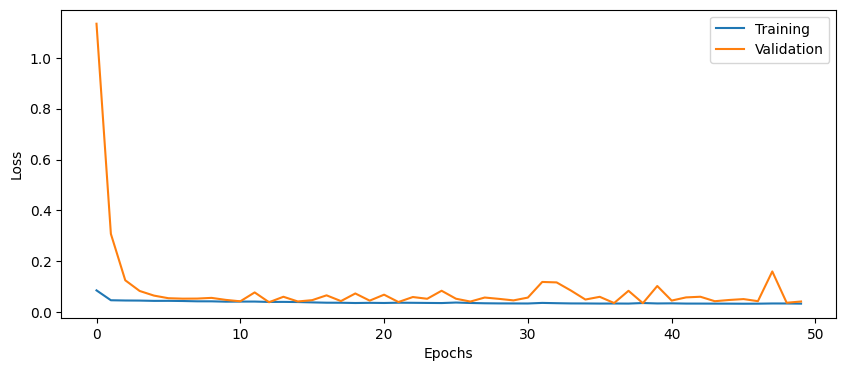

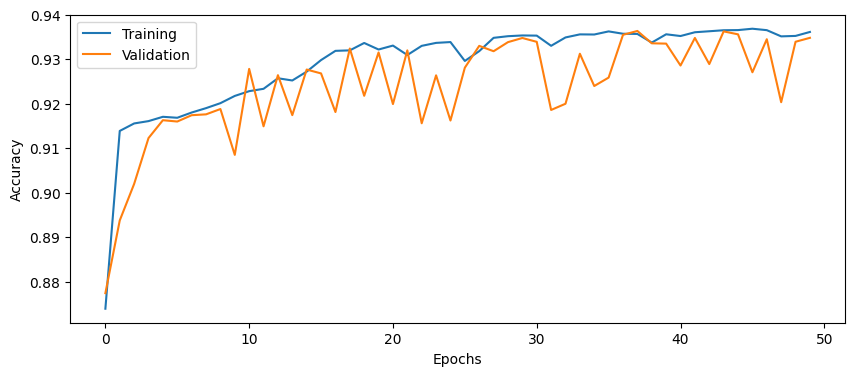

In [48]:
# Setup some training and hyper-parameters
batch_size = 10000
epochs = 50

# Specify the learning rate, the input shape and the loss function
learning_rate = 0.05
input_shape = Xtrain.shape[1]
loss = BinaryFocalCrossentropy()

# Build and train model
best_model = build_DNN(input_shape=input_shape, n_hidden_layers= 5, n_hidden_units= 50, act_fun= 'relu', use_bn= True, loss = loss, optimizer='adam', learning_rate=learning_rate)

best_history= best_model.fit(Xtrain, Ytrain, batch_size, epochs, validation_data=(Xval, Yval), class_weight=class_weights)

# Evaluate model on test data
best_score = best_model.evaluate(Xtest, Ytest)

# ============================================

print('Test loss: %.4f' % best_score[0])
print('Test accuracy: %.4f' % best_score[1])

# Plot the history from the training run
plot_results(best_history)


### **3.2 Automatic hyper parameter search**
The number of hyper parameters that can be tried manually is limited and the process of trying out the different combinations and keeping track of them is time consuming and tedious. Today, there are several libraries available for automatic hyper parameter tuning (see an extensive list [here](https://github.com/balavenkatesh3322/hyperparameter_tuning)). The library that we will use in this lab is `Ray Tune` which can be integrated with many of the deep learning APIs available today (for the full description of the library capabilities see the [documentation](https://docs.ray.io/en/latest/tune/index.html)).


To use the `Ray Tune` functionality we need a function that defines the model training. This will then be used in a wrapper function that defines the hyper parameter search space, the resources available for running the search and the search algorithm. 

Start by implementing the `train_DNN` function in the `utilities.py` file (more detailed instructions are available in `utilities.py`). In the cell below, you can set up the search space and a `tune` ray object that takes the `train_DNN`. The tuner will set `train_DNN`, will select a set of hyper parameters and train several models for us (more information [here](https://docs.ray.io/en/latest/tune/key-concepts.html?_gl=1*j3ryje*_up*MQ..*_ga*NzQyMjIzNzg4LjE3MzY0MTk5MzY.*_ga_0LCWHW1N3S*MTczNjQxOTkzNS4xLjAuMTczNjQxOTkzNS4wLjAuMA..#tune-60-seconds)). 


`Ray Tune` library provides several types of hyper parameter search algorithms, including random and grid search, and Bayesian optimization. In this lab we will be using the default Ray Tune opitmization algorithm which is random serach. More infromation about the available search arlgorithms can be found [here](https://docs.ray.io/en/latest/tune/api/suggestion.html).

#### **<span style="color:red">Question</span>**
15. Run the automatic hyper parameter search with range of possible hyper parameter values as in your manual search. Does the automatic search set of parameters match those that you have found?
16. What are the benefits and drawbacks of automatic hyper parameter search?
   
#### **<span style="color:green">Answers</span>**
[Your answers here]

In [49]:
from pathlib import Path
# import train_DNN
from utilities_AB import train_DNN

# imports for hyperparameter tuning
from ray import tune, train
from ray.tune.schedulers import AsyncHyperBandScheduler

# --------------------------------------------  
# === Your code here =========================
# --------------------------------------------

# Define the hyper parameter, both those that should be searched and those that are fixed.
#  Hyperparameters to search are: act_fun, optimizer, use_bn, n_hidden_layers and n_hidden_units.
# The remaining parameters can be set to fixed values (This is to reduce the search space and time).
# Add the batch size and epochs so that the train_DNN can access them.
hyperparameter_space =  {
            "act_fun": tune.choice(['sigmoid', 'relu']),
            "optimizer": tune.choice(['sgd', 'adam']),
            "use_bn": tune.choice([True, False]),
            "n_hidden_layers": tune.randint(2, 5) ,
            "n_hidden_units": tune.randint(10, 50),
            # here define the fixed parameters
            "loss": BinaryFocalCrossentropy(), 
            "learning_rate": 0.05,
            "use_dropout": False,
            "use_custom_dropout": False,
            "use_variational_layer": False,
            "input_shape": Xtrain.shape[1],
            "print_summary": True,
        }

# specify batch and number of epochs
training_config = {
            "data": (Xtrain, Ytrain, Xval, Yval ),
            "epochs": 40,
            "batch_size": 1000
        }

# specify the number of samples to take from the hyper parameter space and run. The larger the number, the longer the search time.
# Start small (e.g. 2) to test your implementation, then increase.
num_samples = 2

# ============================================


# Definition of the Scheduler. This allows for several models to be trained/stopped/re-started simultaneously 
sched = AsyncHyperBandScheduler(
    metric="mean_accuracy", mode="max",
        time_attr="training_iteration", max_t=400, grace_period=20
    )

# Setting up the tuner.
tuner = tune.Tuner(
        tune.with_resources(tune.with_parameters(train_DNN, training_config=training_config), resources={"cpu": 2, "gpu":0}), # definition of which training function to use and the available resources. Consider adding "gpu":0 to resources if available.
        tune_config=tune.TuneConfig(
            scheduler=sched,
            num_samples=num_samples,
        ),
        run_config=train.RunConfig(
            name="DNN_hp_tuning",
            stop={"mean_accuracy": 1},
            storage_path= Path.cwd() # where to save the summary of the hyper parameter tuning.
        ),
        param_space=hyperparameter_space,
    )

# Run the hyper parameter search.
results = tuner.fit()

(pid=475891) 2026-02-28 18:45:47.810422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=475891) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=475891) E0000 00:00:1772300747.827047  475891 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=475891) E0000 00:00:1772300747.831391  475891 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(train_DNN pid=475892) 2026-02-28 18:45:50.011831: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(train_DNN pid=475892) Model: "sequential"
(train_DNN pid=475892) _________________________________________________________________
(train_DNN pid=475892)  Layer (type)                Output Shape              Param #   
(train_DNN pid=475892) =================================================================
(train_DNN pid=475892)  dense (Dense)               (None, 32)                2976      
(train_DNN pid=475892)                                                                  
(train_DNN pid=475892)  batch_normalization (Batch  (None, 32)                128       
(train_DNN pid=475892)  Normalization)                                                  
(train_DNN pid=475892)                                                                  
(train_DNN pid=475892)  dense_1 (Dense)             (None, 32)                1056      
(train_DNN pid=475892)                                                                  
(train_DNN pid=475892)  batch_normalization_1 (Bat  (None, 32)     

2026-02-28 18:46:47,449	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/alvaro-barbosa/Documents/Linkoping/732A82_Deep_Learning/Labs/deeplearninglabs/2_DNN/2_DNN/DNN_hp_tuning' in 0.0024s.


533/535 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9392 - f1_score: 0.9631


2026-02-28 18:46:47,454	INFO tune.py:1041 -- Total run time: 60.87 seconds (60.83 seconds for the tuning loop).


In [50]:
# Show the best hyper parameter configuration that was found
best_trial = results.get_best_result(metric="mean_accuracy", mode='max')
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.metrics['keras_info']['val_loss']:0.4f}")
print(f"Best trial final validation accuracy: {best_trial.metrics['keras_info']['val_accuracy']:0.4f}")


Best trial config: {'act_fun': 'relu', 'optimizer': 'adam', 'use_bn': True, 'n_hidden_layers': 3, 'n_hidden_units': 32, 'loss': <tf_keras.src.losses.BinaryFocalCrossentropy object at 0x7defa10cd910>, 'learning_rate': 0.05, 'use_dropout': False, 'use_custom_dropout': False, 'use_variational_layer': False, 'input_shape': 92, 'print_summary': True}
Best trial final validation loss: 0.0283
Best trial final validation accuracy: 0.9386


# Part 4: Uncertainty quantification

In the next sections you will explore three methods for model uncertainty estimation:
- Monte Carlo dropout where we take advantage of the dropout layer during inference time.
- Cross validation where we train several models on different splits of data.
- Bayesian neural networks (BNN) where we modify our model definition to allow the model to learn distributions over weights and the output. 

**!Note**: through the next sections, use your best model configuration that you found through hyper parameter tuning (either manual or automatic).

### **4.1 Dropout uncertainty**

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this [paper](http://proceedings.mlr.press/v48/gal16.pdf)

To achieve this, we need to redefine the Keras Dropout. This was already done for you and it is available in `utilities.py` under `myDropout`. Adapt the `build_DNN` function to two boolean arguments, use_dropout and use_custom_dropout; add a standard Dropout layer if use_dropout is true, add a `myDropout` layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 


In [52]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Your best training parameters
batch_size = 10000
epochs = 50
input_shape = Xtrain.shape[1]
loss = BinaryFocalCrossentropy()
learning_rate = 0.03

# Build and train model
model10 = build_DNN(input_shape=input_shape, n_hidden_layers= 5, n_hidden_units= 50, act_fun= 'relu', use_bn= True, loss = loss, optimizer='adam', learning_rate=learning_rate, use_custom_dropout=True)

history10 = model10.fit(Xtrain, Ytrain, batch_size, epochs, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/50
54/54 [==============================] - 2s 25ms/step - loss: 0.0924 - accuracy: 0.8620 - f1_score: 0.9118 - val_loss: 0.0791 - val_accuracy: 0.8732 - val_f1_score: 0.9268
Epoch 2/50
54/54 [==============================] - 1s 22ms/step - loss: 0.0515 - accuracy: 0.9038 - f1_score: 0.9394 - val_loss: 0.0486 - val_accuracy: 0.8712 - val_f1_score: 0.9256
Epoch 3/50
54/54 [==============================] - 1s 22ms/step - loss: 0.0491 - accuracy: 0.9093 - f1_score: 0.9430 - val_loss: 0.0417 - val_accuracy: 0.9127 - val_f1_score: 0.9454
Epoch 4/50
54/54 [==============================] - 1s 23ms/step - loss: 0.0479 - accuracy: 0.9116 - f1_score: 0.9445 - val_loss: 0.0434 - val_accuracy: 0.9127 - val_f1_score: 0.9452
Epoch 5/50
54/54 [==============================] - 1s 22ms/step - loss: 0.0481 - accuracy: 0.9115 - f1_score: 0.9445 - val_loss: 0.0474 - val_accuracy: 0.9118 - val_f1_score: 0.9446
Epoch 6/50
54/54 [==============================] - 1s 23ms/step - loss: 0.0476 - acc

In [53]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model10.evaluate(Xtest, Ytest, verbose=0)
                       
print('Test accuracy: %.4f' % score[1])

Test accuracy: 0.9145


In [54]:
# ============================================
# === Your code here =========================
# ============================================
# Run the testing 100 times, and save the accuracies in an array

model10_acc = []
for i in range(100):
    model10_acc.append(model10.evaluate(Xtest, Ytest, verbose=0)[1])



# Calculate and print mean and std of accuracies
print(np.mean(model10_acc))
print(np.std(model10_acc))

# ============================================

0.9145134812593461
8.997002341802378e-05


### **4.2: Cross validation uncertainty**

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a [help function from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to setup the CV. Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.


In [55]:
from sklearn.model_selection import StratifiedKFold

random_state = 1234 
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

batch_size = 1000
epochs = 50
loss = BinaryFocalCrossentropy()

# Define 10-fold cross validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1234)

# Define where to save the test accuracies
test_accuracies = []

# Loop over cross validation folds
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
  
    Xtrain = X[train_index,:]
    Ytrain = Y[train_index]
    Xtrain = X[test_index,:]
    Ytrain = Y[test_index]

    # Calculate class weights for current split (remember to call the function using the input variable names e.g. class_weight='balanced', etc.)
    value1, value2 = class_weight.compute_class_weight(class_weight = 'balanced' , classes = np.array([0,1]), y = Ytrain)
    class_weights = {0: value1,
                1: value2}
    
    # Rebuild the DNN model, to not continue training on the previously trained model
    model = build_DNN(input_shape=Xtrain.shape[1], n_hidden_layers= 5, n_hidden_units= 50, act_fun= 'relu', use_bn= True, loss = loss, optimizer='adam', learning_rate=learning_rate)

    # Fit the model with training set and class weights for this fold
    history = model10.fit(Xtrain, Ytrain, batch_size, epochs, class_weight=class_weights)
    
    # Evaluate the model using the test set for this fold
    score = model10.evaluate(Xtest, Ytest, verbose=0 )
    
    # Save the test accuracy in an array
    test_accuracies.append(score[1])

# Calculate and print mean and std of accuracies
print(np.mean(test_accuracies))
print(np.std(test_accuracies))

# ============================================



Epoch 1/50
77/77 [==============================] - 1s 6ms/step - loss: 0.2304 - accuracy: 0.5098 - f1_score: 0.6382
Epoch 2/50
77/77 [==============================] - 0s 6ms/step - loss: 0.1744 - accuracy: 0.4914 - f1_score: 0.6160
Epoch 3/50
77/77 [==============================] - 0s 6ms/step - loss: 0.1739 - accuracy: 0.4740 - f1_score: 0.5943
Epoch 4/50
77/77 [==============================] - 0s 5ms/step - loss: 0.1725 - accuracy: 0.5061 - f1_score: 0.6317
Epoch 5/50
77/77 [==============================] - 0s 5ms/step - loss: 0.1709 - accuracy: 0.4322 - f1_score: 0.5352
Epoch 6/50
77/77 [==============================] - 0s 5ms/step - loss: 0.1698 - accuracy: 0.4326 - f1_score: 0.5345
Epoch 7/50
77/77 [==============================] - 0s 6ms/step - loss: 0.1683 - accuracy: 0.4283 - f1_score: 0.5284
Epoch 8/50
77/77 [==============================] - 0s 5ms/step - loss: 0.1678 - accuracy: 0.4373 - f1_score: 0.5411
Epoch 9/50
77/77 [==============================] - 0s 6ms/step 

### **4.3 Bayesian neural networks (BNN)**

Instead of mimicking Bayesian inference through MC dropout (see more details in this [paper](https://proceedings.mlr.press/v48/gal16.html)), what if we could build a model that can inherently give us a way to probe both model uncertainty (i.e. [epistemic uncertainty](https://link.springer.com/article/10.1007/s10994-021-05946-3) cause by few training samples) and data uncertainty (i.e. [aleatoric uncertainty](https://link.springer.com/article/10.1007/s10994-021-05946-3))? 

One way to achieve this is to train models to learn distributions over weights in the layers and over the output. This can be achieved by using TenssorFlow probability (see the [documentation](https://www.tensorflow.org/probability) for an in-depth description of all the functionalities). In this example we will only scratch the surface of the capabilities that a probabilistic deep learning approach has to offer, by addressing only model uncertainty. 

To start with, think about a BNN as an extension of your classical DNN, where during training instead of learning a weights for each 'connection' in the network, we ask the model to lean a distribution. After model training, during inference time, we sample from the learned distributions to obtain the weights used in the model in the forward pass. The modifications that we have to implement in our `build_DNN` function are the following:
- Substitute the hidden `Dense` layers with [`DenseVariational`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseVariational) layers (this can be found under tensorflow-probability.layers). Do not forget to specify the `kl_weight` as 1/ number of iterations per epoch ([reference](https://arxiv.org/abs/1505.05424)). 
- Define the prior weights distribution (`make_prior_fn` input in the `DenseVariational`): this is the distribution that we expect the weights to have prior having seen the data. In this example we will not train the prior distribution.
- Define the posterior weights distribution (`make_posterior_fn` input in the `DenseVariational`): this is the distribution that we expect the model to learn during training. Since we do not know at priory which is the posterior distribution, we let it be very general (i.e. multivariate Gaussian distribution) which parameters are learned by the model. 

You will find the `BNN_prior` and `BNN_posterior` defined for you in the `utilities.py` file. Update the `build_DNN` to accept a new boolean input `use_variational_layer` that when true substitutes the hidden `Dense` layers with the `DenseVariational` layers. 

**!NOTE** As you will see, training the BNN model is more computationally demanding and is more prone to over-fitting. Reduce the learning rate and increase the number of epochs to address this issue.

#### **<span style="color:red">Questions</span>**
17. (MC dropout) What is the mean and the standard deviation of the test accuracy after evaluating the model on 100 times?
18. (CV) What is the mean and the standard deviation of the test accuracy?
19. (CV) What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.
20. (BNN) Build the BNN model and look at the number of parameters. Is there a difference between the previous DNN and the BNN? Why is that?
21. (BNN) Without training the model, evaluate the model a twice on the validation set: do you obtain the same validation accuracy? Why
22. Think of at least one advantage and one disadvantage for each of the three uncertainty estimation methods.
    
    
#### **<span style="color:green">Answer</span>**
[Your answers here]


In [56]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Your best training parameters
batch_size = 5000
epochs = 200
input_shape = Xtrain.shape[1]
loss = BinaryFocalCrossentropy()
learning_rate = 0.1

# Build and train model
model11 = build_DNN(input_shape=input_shape, n_hidden_layers= 2, n_hidden_units= 10, act_fun= 'sigmoid', use_bn= False, loss = loss, optimizer='adam', learning_rate=learning_rate, use_variational_layer=True, print_summary=True, kl_weight= batch_size / Xtrain.shape[0])

history11 = model11.fit(Xtrain, Ytrain, batch_size, epochs, validation_data=(Xval, Yval), class_weight=class_weights)
# ============================================

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVa  (None, 10)                433845    
 riational)                                                      
                                                                 
 dense_variational_1 (Dense  (None, 10)                6215      
 Variational)                                                    
                                                                 
 dense_variational_2 (Dense  (None, 1)                 77        
 Variational)                                                    
                                                                 
Total params: 440137 (1.68 MB)
Trainable params: 440137 (1.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
16/16 [==============================] - 2s 50ms/step - loss: 792.8054 

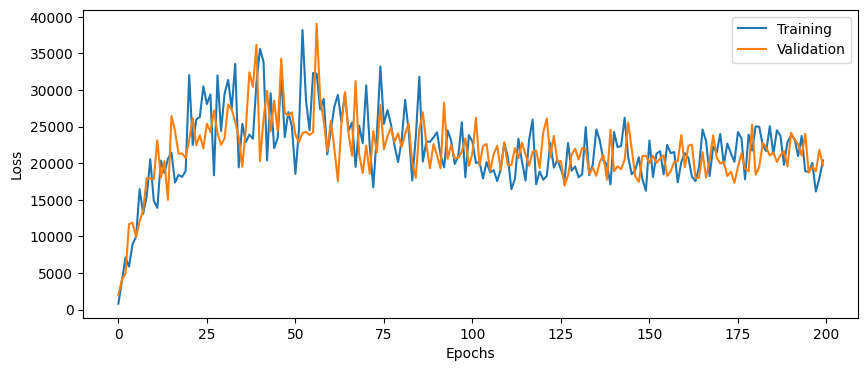

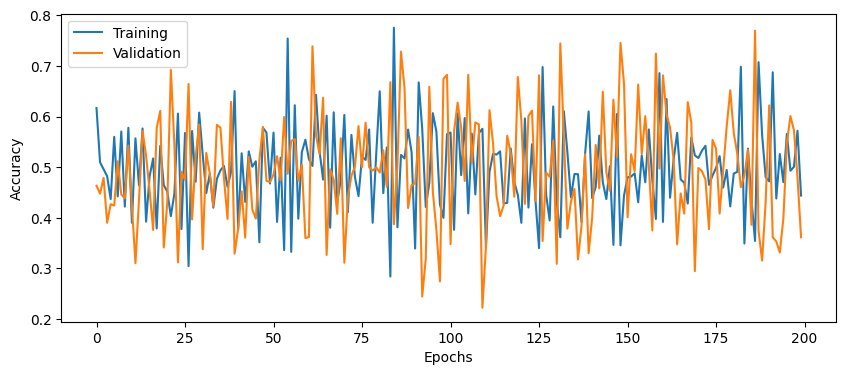

In [57]:
# Plot the history from the training run
plot_results(history11) 

As we have done for the MC dropout uncertainty estimation, run the evaluation on the test set 100 times and show the mean and standard deviation.

In [ ]:
# ============================================
# === Your code here =========================
# ============================================
# Run the testing 100 times, and save the accuracies in an array

n_runs = ???

# Define where to save the test accuracies
test_accuracies = ???

for _ in ???:
    # predict the test set
    pred = ???

    # Save predictions
    ???
    
# Calculate and print mean and std of accuracies
???
# ============================================

# Part 5: DNN for regression

A similar DNN can be used for regression, instead of classification.

#### **<span style="color:red">Questions</span>**
23. How would you change the DNN used in this lab in order to use it for regression instead?

#### **<span style="color:green">Answer</span>**
[Your answers here]

## Report

Send in this jupyter notebook, with answers to all questions.